## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

## Next, calibrate the camera and undistort. Apply to raw images

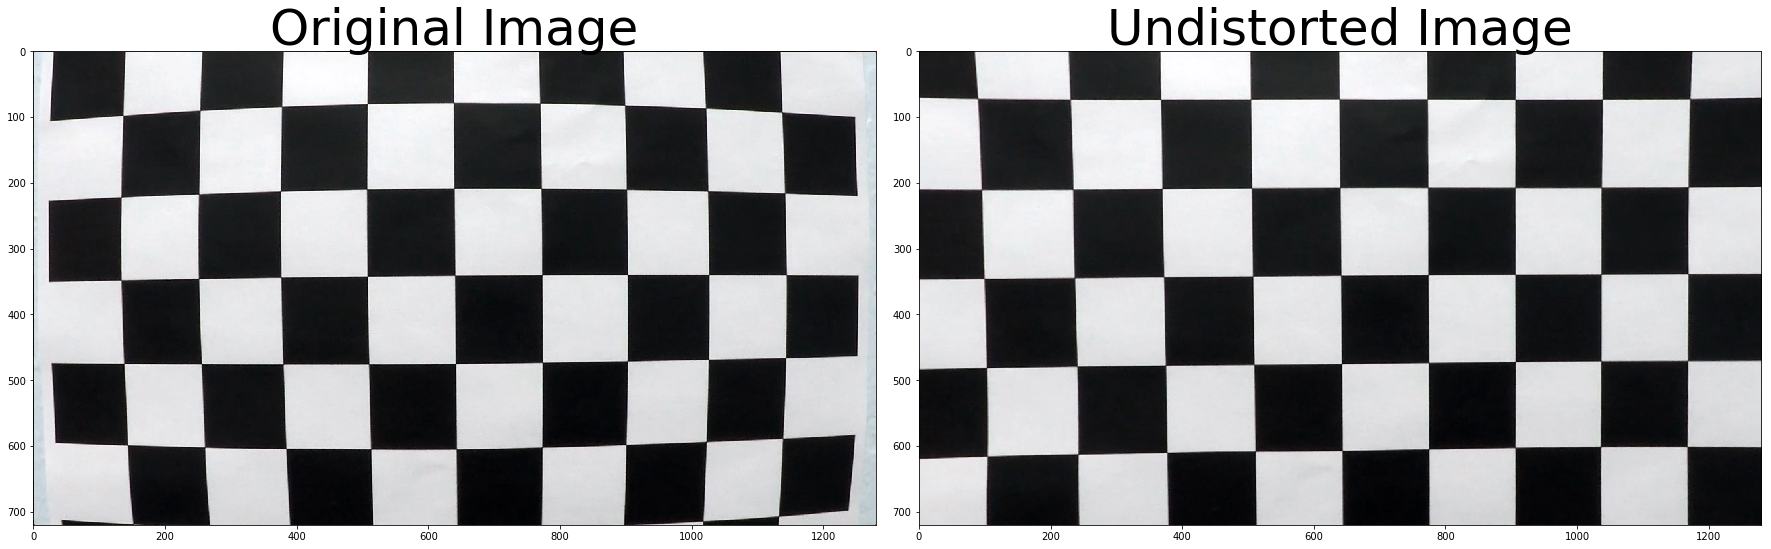

In [2]:
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist


test_img_path = "camera_cal/calibration1.jpg"
img = cv2.imread(test_img_path)
undistorted = cal_undistort(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Use color transforms, gradients, etc., to create a thresholded binary image.

### First, apply Sobel operator 

In [3]:
import matplotlib.image as mpimg
import pickle

# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0) if orient=='x' else cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    #plt.imshow(sxbinary, cmap='gray')
    # 6) Return this mask as your binary_output image
    return sxbinary


'''
# Read in an image and grayscale it
image = mpimg.imread('../test_images/test4.jpg')
# Run the function
grad_binary = abs_sobel_thresh(image, orient='x', thresh_min=20, thresh_max=100)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
'''

# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

'''
# Run the function
mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(50, 100))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
'''

# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

'''
# Run the function
dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.8, 1.3))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
'''

"\n# Run the function\ndir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.8, 1.3))\n# Plot the result\nf, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))\nf.tight_layout()\nax1.imshow(image)\nax1.set_title('Original Image', fontsize=50)\nax2.imshow(dir_binary, cmap='gray')\nax2.set_title('Thresholded Grad. Dir.', fontsize=50)\nplt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)\n"

In [4]:
def get_combine_sober(image):
    gradx = abs_sobel_thresh(image, orient='x', thresh_min=20, thresh_max=100)
    grady = abs_sobel_thresh(image, orient='y', thresh_min=20, thresh_max=100)
    mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(50, 100))
    dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.8, 1.3))

    combined_sober = np.zeros_like(dir_binary)
    combined_sober[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    return combined_sober

### Second, apply Saturation color filter

In [5]:
# Convert to HLS color space and separate the S channel
# Note: img is the undistorted image
def get_color_binary(image):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    return s_binary

### Combine color filter and sober gradient filter

In [6]:
# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors

def get_binary(image):
    sober_binary = get_combine_sober(image)
    color_binary = get_color_binary(image)
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(color_binary)
    combined_binary[(sober_binary == 1) | (color_binary == 1)] = 1
    
    return combined_binary

### Third, apply a perspective transform to rectify binary image ("birds-eye view").

In [7]:
def get_perspective_transform(image):
    img_size = (image.shape[1], image.shape[0])

    src = np.float32(
         [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
         [((img_size[0] / 6) - 10), img_size[1]],
         [(img_size[0] * 5 / 6) + 60, img_size[1]],
         [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    dst = np.float32(
         [[(img_size[0] / 4), 0],
         [(img_size[0] / 4), img_size[1]],
         [(img_size[0] * 3 / 4), img_size[1]],
         [(img_size[0] * 3 / 4), 0]])
    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(image, M, img_size)
    return warped

def get_inv_perspective_transform(image):
    img_size = (image.shape[1], image.shape[0])

    src = np.float32(
         [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
         [((img_size[0] / 6) - 10), img_size[1]],
         [(img_size[0] * 5 / 6) + 60, img_size[1]],
         [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    dst = np.float32(
         [[(img_size[0] / 4), 0],
         [(img_size[0] / 4), img_size[1]],
         [(img_size[0] * 3 / 4), img_size[1]],
         [(img_size[0] * 3 / 4), 0]])
    
    # Given src and dst points, calculate the perspective transform matrix
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    inv_warped = cv2.warpPerspective(image, Minv, img_size)
    return inv_warped

## Detect lane pixels and fit to find the lane boundary.

In [8]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty


def fit_polynomial(leftx, lefty, rightx, righty):
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit

In [9]:
def fit_poly(img_shape, left_fit, right_fit):
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

## Determine the curvature of the lane and vehicle position with respect to center.

In [10]:
def measure_curvature_real(ploty, left_fit_cr, right_fit_cr):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

In [11]:
def measure_vehicle_position(left_fitx, right_fitx, center_pos=640):
    lane_center = left_fitx[-1] + (right_fitx[-1] - left_fitx[-1])/2
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    off_meter = (lane_center - center_pos) * xm_per_pix
    return off_meter

## Warp the detected lane boundaries back onto the original image.

In [12]:
def draw_poly_on_binary_warped(binary_warped, left_fitx, right_fitx):
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)

    left_curve = np.vstack((left_fitx,ploty)).astype(np.int32).T
    right_curve = np.vstack((right_fitx,ploty)).astype(np.int32).T
    
    cv2.polylines(window_img, [left_curve],  False,  (255, 0, 0),  20)
    cv2.polylines(window_img, [right_curve],  False,  (255, 0, 0),  20)
    
    # Combine the result with the original image
    #result = cv2.addWeighted(window_img, 0.8, orig_warped, 1, 0)
    
    return window_img

## Write estimation of position and curvature on image

In [13]:
def write_curvature_and_position(image, curvature, position):
    curvature = round(min(curvature), 2)
    position = round(position, 2)
    my_text = 'Curvature: {}, Position: {}'.format(str(curvature),str(position))
    
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (200,100)
    fontScale              = 1
    fontColor              = (255,255,255)
    lineType               = 2

    cv2.putText(image, my_text,
        bottomLeftCornerOfText, 
        font, 
        fontScale,
        fontColor,
        lineType)
    return image

Text(0.5,1,'With Curvature and position')

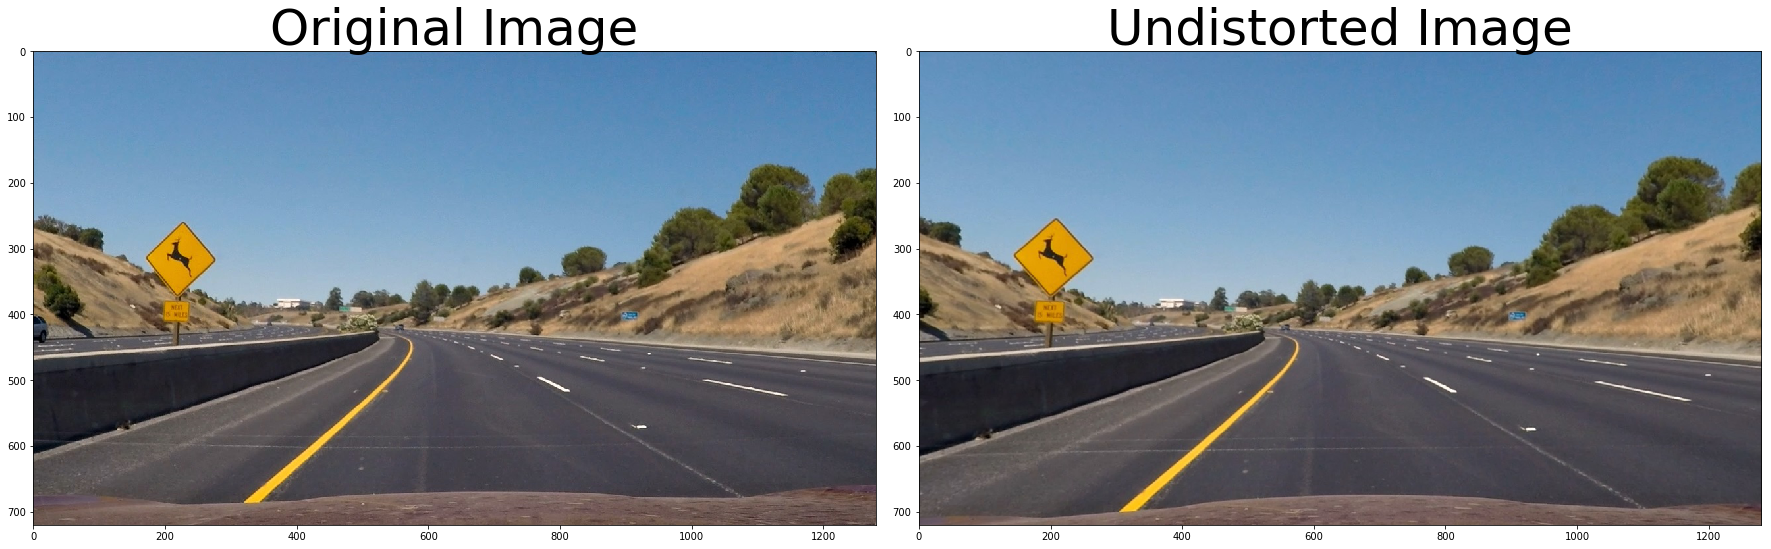

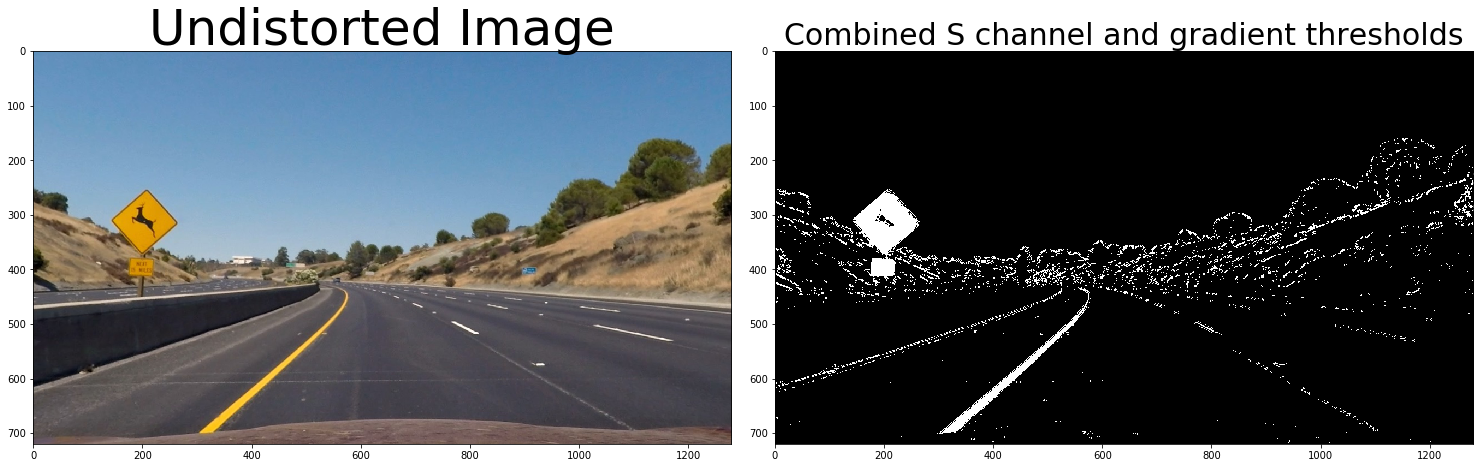

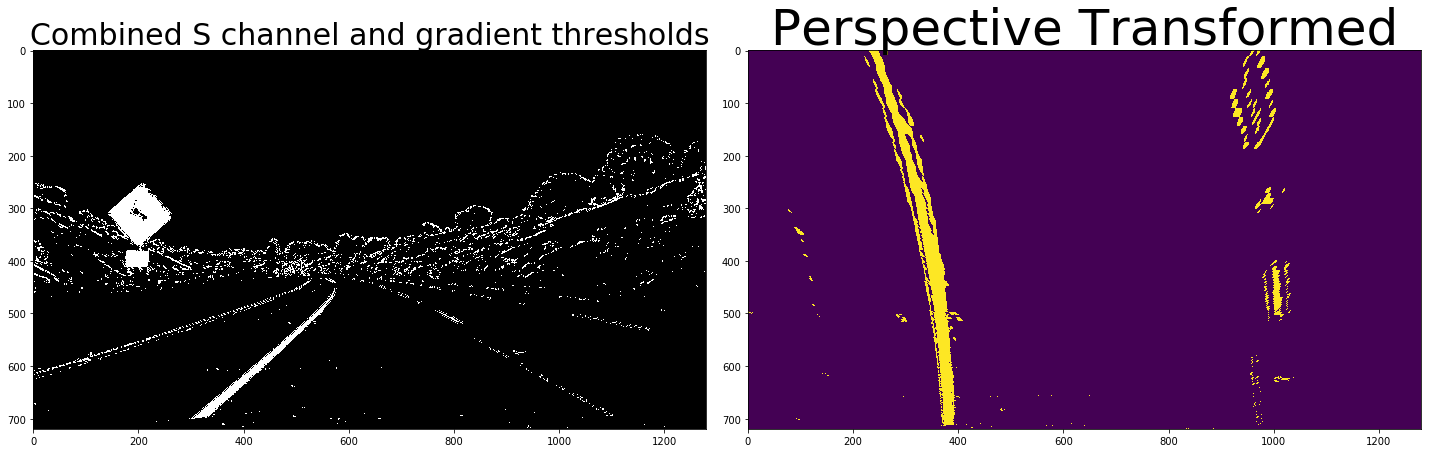

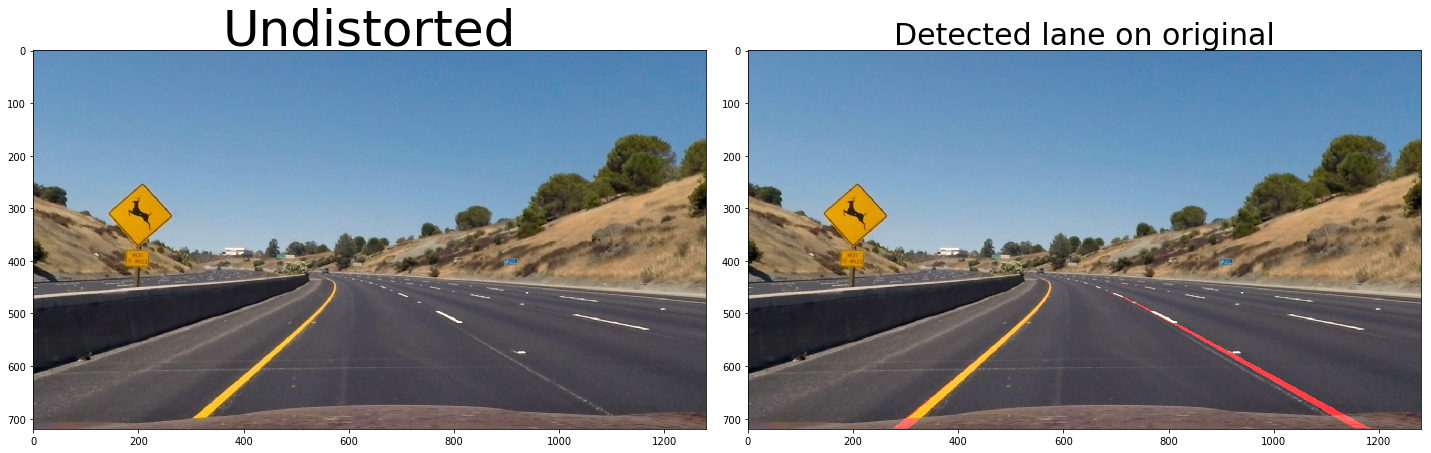

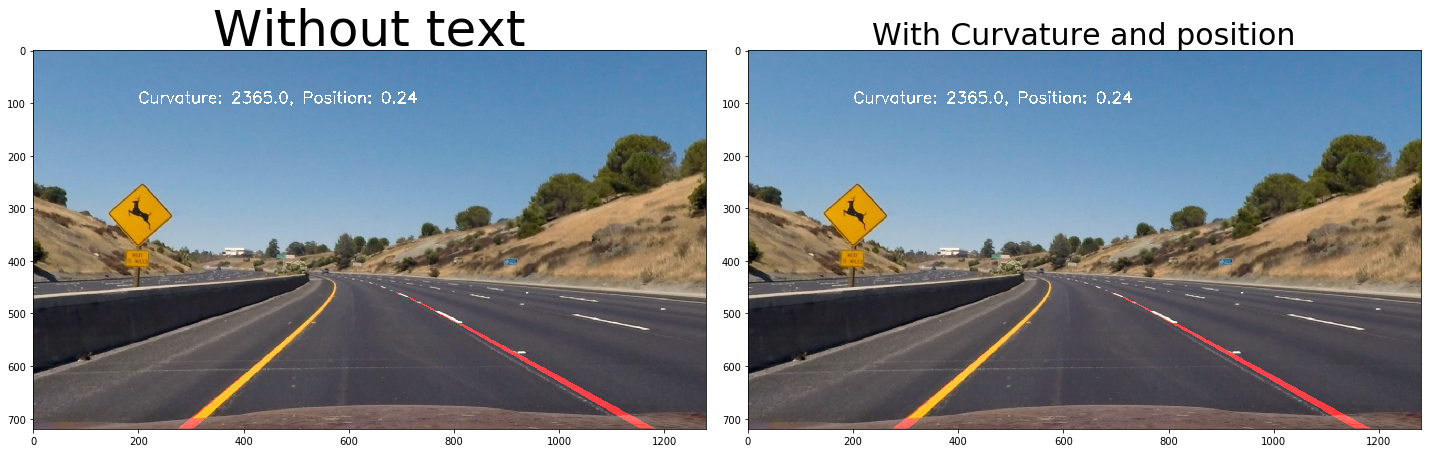

In [14]:
# Pipeline
test_img_path = "test_images/test2.jpg"
image = mpimg.imread(test_img_path)
# apply carmera calibraton and distort
undistorted = cal_undistort(image, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# get both sober and color binary
masked_image = get_binary(undistorted)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.tight_layout()
ax1.imshow(undistorted)
ax1.set_title('Undistorted Image', fontsize=50)
ax2.imshow(masked_image, cmap='gray')
ax2.set_title('Combined S channel and gradient thresholds', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# get perspective transform on binary
warped_image = get_perspective_transform(masked_image)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.tight_layout()
ax1.imshow(masked_image, cmap="gray")
ax1.set_title('Combined S channel and gradient thresholds', fontsize=30)
ax2.imshow(warped_image)
ax2.set_title('Perspective Transformed', fontsize=50)

# draw detected lane on original image
# find left right x y lane points
leftx, lefty, rightx, righty = find_lane_pixels(warped_image)
# fit in polynomial 
left_fit, right_fit = fit_polynomial(leftx, lefty, rightx, righty)
# find points on the polynomial
left_fitx, right_fitx, ploty = fit_poly(warped_image.shape, left_fit, right_fit)
# draw fited pionts 
drawed_warped = draw_poly_on_binary_warped(warped_image, left_fitx, right_fitx)    
# invert the drawing
inv_drawed_warped = get_inv_perspective_transform(drawed_warped)
result = cv2.addWeighted(inv_drawed_warped, 0.8, undistorted, 1, 0)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.tight_layout()
ax1.imshow(undistorted)
ax1.set_title('Undistorted', fontsize=50)
ax2.imshow(result)
ax2.set_title('Detected lane on original', fontsize=30)

# draw estimation of position and curvature
curvature = measure_curvature_real(ploty, left_fit, right_fit)
position = measure_vehicle_position(left_fitx, right_fitx)
out_img = write_curvature_and_position(result, curvature, position)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.tight_layout()
ax1.imshow(result)
ax1.set_title('Without text', fontsize=50)
ax2.imshow(out_img)
ax2.set_title('With Curvature and position', fontsize=30)

In [15]:
def pipeline(image):
    # Pipeline
    # apply carmera calibraton and distort
    undistorted = cal_undistort(image, objpoints, imgpoints)
    # get both sober and color binary
    masked_image = get_binary(undistorted)
    # get perspective transform on binary
    warped_image = get_perspective_transform(masked_image)
    # draw detected lane on original image
    # find left right x y lane points
    leftx, lefty, rightx, righty = find_lane_pixels(warped_image)
    # fit in polynomial 
    left_fit, right_fit = fit_polynomial(leftx, lefty, rightx, righty)
    # find points on the polynomial
    left_fitx, right_fitx, ploty = fit_poly(warped_image.shape, left_fit, right_fit)
    # draw fited pionts 
    drawed_warped = draw_poly_on_binary_warped(warped_image, left_fitx, right_fitx)    
    # invert the drawing
    inv_drawed_warped = get_inv_perspective_transform(drawed_warped)
    result = cv2.addWeighted(inv_drawed_warped, 0.8, undistorted, 1, 0)
    # draw estimation of position and curvature
    curvature = measure_curvature_real(ploty, left_fit, right_fit)
    position = measure_vehicle_position(left_fitx, right_fitx)
    out_img = write_curvature_and_position(result, curvature, position)
    return out_img

#test_img_path = "../test_images/test4.jpg"
#plt.figure(figsize = (20,10))
#plt.imshow(pipeline(test_img_path))

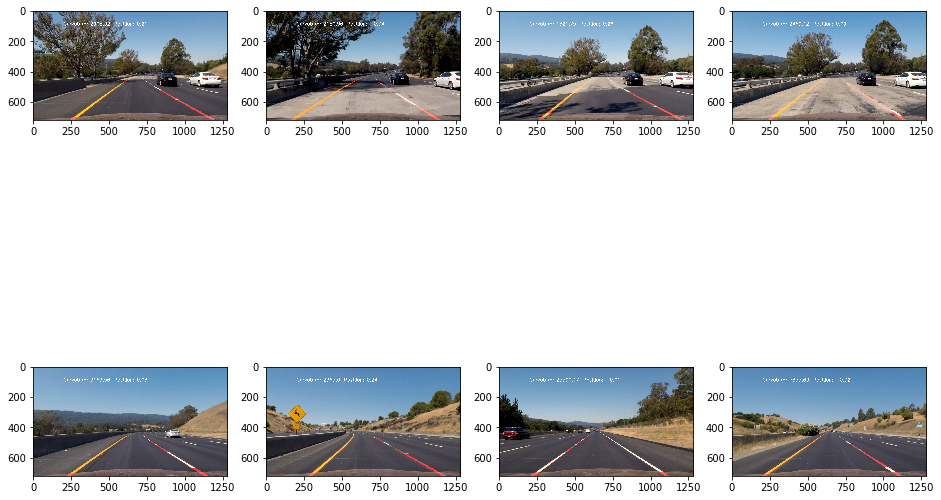

In [16]:
# test images
import os
test_imgs_folder = os.path.join(os.getcwd(), "test_images/")
output_imgs_folder = os.path.join(os.getcwd(), "output_images/")
test_imgs = os.listdir("test_images/")

w=10
h=5
fig=plt.figure(figsize=(16, 12))
columns = 4
rows = 2
for i in range(1, columns*rows+1):
    img = mpimg.imread(os.path.join(test_imgs_folder, test_imgs[i-1]))
    img = pipeline(img)
    cv2.imwrite(os.path.join(output_imgs_folder, test_imgs[i-1]), cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [245]:
# video
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_image(image):
    result = pipeline(image)
    return result

white_output = 'output_images/project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("../project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ../output_images/project_video_output.mp4
[MoviePy] Writing video ../output_images/project_video_output.mp4


100%|█████████▉| 1260/1261 [21:05<00:01,  1.00s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output_images/project_video_output.mp4 

CPU times: user 21min 14s, sys: 54.2 s, total: 22min 8s
Wall time: 21min 5s
